### 1. read the data and data processing

read the transaction data(csv or json)

In [1]:
import pandas as pd

In [3]:
# read sample.csv
transaction_df = pd.read_csv("sample.csv")
# data processing
transaction_df = transaction_df.iloc[3:]
date_time_split = transaction_df['Portfolio ID'].str.split('T', expand=True)
transaction_df['date'] = date_time_split[0]
transaction_df['time'] = date_time_split[1].str[:8]
transaction_df['time'] = pd.to_datetime(transaction_df['time'],format= '%H:%M:%S' ).dt.time

transaction_df = transaction_df.rename(columns={'User Name': 'tic', 'Cash Left':'Qty','Unnamed: 7':'Amount'})

transaction_df = transaction_df[['date','time','tic','Qty','Amount']]
transaction_df['Qty'] = pd.to_numeric(transaction_df['Qty'], errors='coerce', downcast='integer')
transaction_df['Amount'] = pd.to_numeric(transaction_df['Amount'], errors='coerce', downcast='integer')

transaction_df['Price'] = abs(transaction_df['Amount']/transaction_df['Qty'])
transaction_df.loc[transaction_df['Amount'] < 0, 'Qty'] *= -1

transaction_df['time'] = pd.to_datetime(transaction_df['time'],format= '%H:%M:%S' ).dt.time
tran = transaction_df.groupby(['date','tic'])['Qty'].sum()
cha = transaction_df.groupby(['date','tic'])['Amount'].sum()
my_dataframe = pd.DataFrame({'Qty_chg': tran})
my_dataframe['Amount_chg'] = cha
my_dataframe['Qty']  = my_dataframe.groupby(['tic'])['Qty_chg'].cumsum()
my_dataframe['Amount']  = my_dataframe['Amount_chg'].cumsum()

get the daily return data

In [4]:
from yahoodownloader import YahooDownloader 

tickers = set(transaction_df['tic'])
Start_Date = '2023-05-22'

End_Date = '2023-11-03'

daily_return_df = YahooDownloader(start_date = Start_Date,
                     end_date = End_Date,
                     ticker_list = tickers).fetch_data()


daily_return_df = daily_return_df.drop(['open','high','low','volume'], axis=1)
daily_return_df = daily_return_df.set_index(['date','tic'])

daily_return_df.head()

Shape of DataFrame:  (1265, 8)


close  day
date       tic                  
2023-05-22 AAPL  173.736191    0
           AMZN  115.010002    0
           DX     10.391145    0
           FAST   54.724548    0
           KO     60.564579    0

In [5]:
merged_data = pd.merge(daily_return_df, my_dataframe, left_on=['date','tic'], right_on=['date','tic'], how='outer', indicator=True)

merge the daily return and transaction data

In [6]:
initial_balance = 1000000
merged_data = pd.merge(daily_return_df, my_dataframe, left_on=['date','tic'], right_on=['date','tic'], how='outer', indicator=True)
merged_data['Amount'] = merged_data['Amount'].ffill()
merged_data['Qty']  = merged_data.groupby(['tic'])['Qty'].ffill()

merged_data = merged_data.drop(['day','_merge'],axis=1)
merged_data =merged_data.fillna(0)
merged_data['Investing_value'] = merged_data['close'] * merged_data['Qty']
merged_data['Cash'] = initial_balance - merged_data['Amount']

merged_data.head()

close  Qty_chg  Amount_chg     Qty    Amount  \
date       tic                                                       
2023-05-22 AAPL  173.736191   2000.0    348000.0  2000.0  348000.0   
           AMZN  115.010002   1500.0    172500.0  1500.0  520500.0   
           DX     10.391145      0.0         0.0     0.0  520500.0   
           FAST   54.724548      0.0         0.0     0.0  520500.0   
           KO     60.564579      0.0         0.0     0.0  520500.0   

                 Investing_value      Cash  
date       tic                              
2023-05-22 AAPL    347472.381592  652000.0  
           AMZN    172515.003204  479500.0  
           DX           0.000000  479500.0  
           FAST         0.000000  479500.0  
           KO           0.000000  479500.0

In [7]:
#merged_data[merged_data['Qty']>0].to_excel('merged2.xlsx')

In [8]:
merged_data

close  Qty_chg  Amount_chg     Qty     Amount  \
date       tic                                                        
2023-05-22 AAPL  173.736191   2000.0    348000.0  2000.0  348000.00   
           AMZN  115.010002   1500.0    172500.0  1500.0  520500.00   
           DX     10.391145      0.0         0.0     0.0  520500.00   
           FAST   54.724548      0.0         0.0     0.0  520500.00   
           KO     60.564579      0.0         0.0     0.0  520500.00   
...                     ...      ...         ...     ...        ...   
2023-11-02 NKE   105.080002      0.0         0.0   400.0  994957.46   
           PFE    30.094257      0.0         0.0   100.0  994957.46   
           PYPL   55.060001      0.0         0.0  2500.0  994957.46   
           SBUX   99.463448      0.0         0.0   750.0  994957.46   
           TSLA  218.509995      0.0         0.0  1100.0  994957.46   

                 Investing_value       Cash  
date       tic                               
2023-05-22 AAPL    347472.381592  652000.00  
           AMZN    172515.003204  479500.00  
           DX           0.000000  479500.00  
           FAST         0.000000  479500.00  
           KO           0.000000  479500.00  
...                          ...        ...  
2023-11-02 NKE      42032.000732    5042.54  
           PFE       3009.425735    5042.54  
           PYPL    137650.003433    5042.54  
           SBUX     74597.585678    5042.54  
           TSLA    240360.993958    5042.54  

[1265 rows x 7 columns]

In [32]:
#merged_data.to_excel('merged_data.xlsx')

In [9]:
investing_value = merged_data.groupby('date')['Investing_value'].sum()

In [10]:
cash = merged_data.groupby('date')['Cash'].last()

In [11]:
#cash.to_excel('cash.xlsx')

In [12]:
portfolio_value = investing_value + cash

In [13]:
portfolio_value

date
2023-05-22    1.001116e+06
2023-05-23    9.888742e+05
2023-05-24    9.872378e+05
2023-05-25    9.827476e+05
2023-05-26    1.005590e+06
                  ...     
2023-10-27    9.872286e+05
2023-10-30    9.915256e+05
2023-10-31    9.984235e+05
2023-11-01    1.013876e+06
2023-11-02    1.052858e+06
Length: 115, dtype: float64

### 2. Encapsulate all the process and get our portfolio daily return

In [2]:
from dataprocessing import DataProcessing           
# find the code in dataprocessing.py

Start_Date = '2023-05-19'
End_Date = '2023-11-03'
csv_file = 'sample.csv'

processor = DataProcessing(Start_Date, End_Date, csv_file)
portfolio_value = processor.portfolio_value
sp500 = processor.sp500_portfolio

In [3]:
from financialmetrics import FinancialMetrics 

In [4]:
fm = FinancialMetrics(portfolio_value, sp500)

In [6]:
import pandas as pd
Sample_Portfolio = "Sample Portfolio"


HPR = fm.holding_period_return()
ret = fm.annualized_return()

Beta = fm.beta()
max_drawdown = fm.max_drawdown()

Sortino = fm.sortino_ratio()
Treynor = fm.treynor_ratio()

Calmar = fm.calmar_ratio()
tracking_error = fm.tracking_error()

best_ret = fm.best_return()
worst_ret = fm.worst_return()

# Additional metrics
CAGR = fm.CAGR()
std_dev = fm.standard_deviation()
Alpha = fm.alpha()
Jensens_Alpha = fm.jensens_alpha()
correlation_sp500 = fm.correlation_with_sp500()
Sharpe = fm.sharpe_ratio()
R_Squared = fm.r_squared()

VaR = fm.VaR()

# Create a dictionary with your data
data = {
    "Start Date": [Start_Date],
    "End Date": [End_Date],
    "Portfolio Name": [Sample_Portfolio],
    "Annualized Return": [ret],
    "CAGR": [CAGR],  # Add CAGR
    "Standard Deviation": [std_dev],  # Add Standard Deviation
    "Beta": [Beta],
    "Alpha": [Alpha],  # Add Alpha
    "Jensen’s Alpha": [Jensens_Alpha],  # Add Jensen’s Alpha
    "Correlation with S&P 500": [correlation_sp500],  # Add Correlation with S&P 500
    "Sharpe Ratio": [Sharpe],  # Add Sharpe Ratio
    "R-Squared": [R_Squared],  # Add R-Squared
    "Max Drawdown": [max_drawdown],
    "Sortino Ratio": [Sortino],
    "Treynor Ratio": [Treynor],
    "Calmar Ratio": [Calmar],
    "Tracking Error": [tracking_error],
    "VaR": [VaR],  
    "Best Return": [best_ret],
    "Worst Return": [worst_ret],
}

# Now the data dictionary is ordered as per your specified sequence.


# Create a DataFrame from the data
df = pd.DataFrame(data)

# Export the DataFrame to an Excel file
#df.to_excel("portfolio_metrics1.xlsx", index=False,startrow=1)




In [7]:
df.to_excel("portfolio_metrics1.xlsx", index=False,startrow=1)

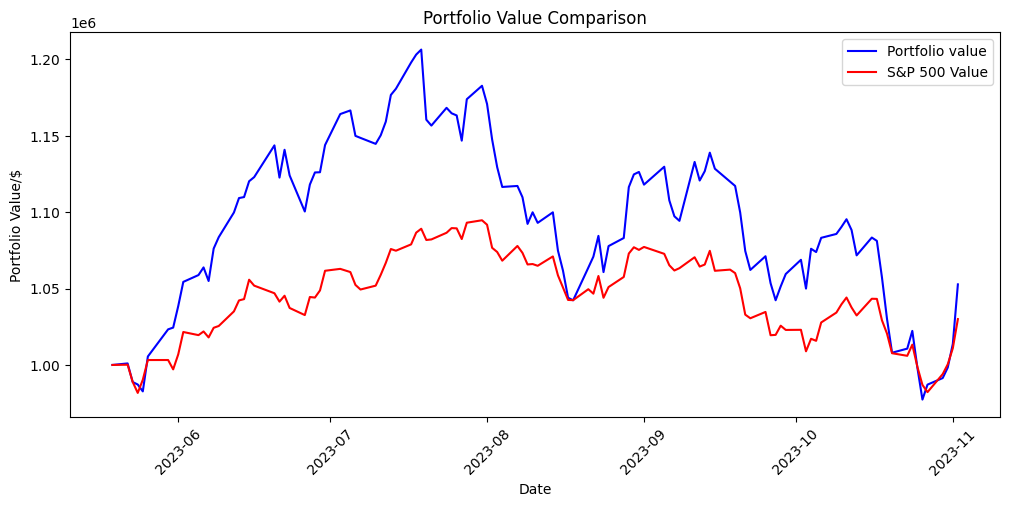

In [6]:
processor.plot()